# Klasifikasi Sampah Organik dan Non-Organik menggunakan Deep Learning

## 📌 Workflow Cepat

**Jika model sudah ditraining sebelumnya:**
1. Jalankan Cell 2 (Import Libraries)
2. Jalankan Cell 4 (Quick Start - Load Model)
3. Langsung ke Cell 26+ untuk deteksi realtime

**Jika belum training:**
- Jalankan semua cell secara berurutan dari awal

---

## Pendahuluan

### Pentingnya Klasifikasi Sampah

Klasifikasi sampah merupakan langkah penting dalam pengelolaan sampah yang berkelanjutan. Dengan memisahkan sampah organik dan non-organik, kita dapat:

1. **Meningkatkan Efisiensi Daur Ulang**: Sampah non-organik dapat didaur ulang menjadi produk baru
2. **Mengurangi Pencemaran**: Sampah organik dapat diolah menjadi kompos, mengurangi penggunaan lahan TPA
3. **Menghemat Energi**: Daur ulang membutuhkan energi lebih sedikit dibanding produksi dari bahan mentah
4. **Meningkatkan Kesadaran Lingkungan**: Sistem otomatis membantu masyarakat memahami pentingnya pemilahan sampah

### Tujuan dan Manfaat Project

**Tujuan:**
- Membangun model deep learning yang dapat mengklasifikasikan sampah menjadi kategori organik dan non-organik
- Mencapai akurasi minimal 90% untuk penggunaan praktis
- Menciptakan solusi yang dapat direplikasi dan digunakan untuk edukasi

**Manfaat:**
- Dapat diintegrasikan ke dalam sistem pemilah sampah otomatis
- Sebagai alat edukasi untuk meningkatkan kesadaran lingkungan
- Dapat dikembangkan lebih lanjut untuk klasifikasi multi-kategori
- Membantu dalam pengelolaan sampah yang lebih efisien


## 1. Import Libraries

Mengimpor semua library yang diperlukan untuk project ini.

**Catatan:** Jika model sudah ditraining sebelumnya, bisa langsung ke bagian "Quick Start" di bawah untuk load model tanpa training ulang.


In [1]:
# Import library yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import cv2

# YOLO untuk object detection dengan bounding box
try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
    print("✅ YOLO (Ultralytics) tersedia")
except ImportError:
    YOLO_AVAILABLE = False
    print("⚠️ YOLO tidak tersedia. Install dengan: pip install ultralytics")
    print("   Fitur deteksi dengan bounding box akan menggunakan metode alternatif")

# Set random seed biar hasilnya konsisten
np.random.seed(42)
tf.random.set_seed(42)

print("\nTensorFlow:", tf.__version__)
print("GPU tersedia:", len(tf.config.list_physical_devices('GPU')) > 0)
print("OpenCV:", cv2.__version__)


✅ YOLO (Ultralytics) tersedia

TensorFlow: 2.20.0
GPU tersedia: False
OpenCV: 4.11.0


### ⚡ Quick Start (Jika Model Sudah Ditraining)

**Gunakan cell ini jika model sudah ditraining sebelumnya dan ingin langsung menggunakan model tanpa training ulang.**

Langkah:
1. Jalankan cell import libraries (Cell 2)
2. Jalankan cell ini untuk load model yang sudah ada
3. Langsung ke bagian 8 untuk deteksi realtime


In [2]:
# Quick Start - Load Model yang Sudah Ditraining
# ⚡ GUNAKAN CELL INI jika model sudah ditraining sebelumnya
# Tidak perlu training ulang, langsung load model dan gunakan!

import os

print("="*60)
print("QUICK START - LOAD MODEL")
print("="*60)

# Cek apakah model file ada
model_files = []
if os.path.exists('waste_classification_model.h5'):
    model_files.append('waste_classification_model.h5')
if os.path.exists('best_model.h5'):
    model_files.append('best_model.h5')

if model_files:
    print("\n✅ Model file ditemukan:")
    for f in model_files:
        size = os.path.getsize(f) / (1024*1024)
        print(f"  - {f} ({size:.2f} MB)")
    
    # Load model
    try:
        if 'waste_classification_model.h5' in model_files:
            model = keras.models.load_model('waste_classification_model.h5')
            print("\n✅ Model berhasil dimuat dari 'waste_classification_model.h5'")
        else:
            model = keras.models.load_model('best_model.h5')
            print("\n✅ Model berhasil dimuat dari 'best_model.h5'")
        
        # Set konfigurasi yang diperlukan
        IMG_SIZE = 224
        print(f"✅ IMG_SIZE diset ke {IMG_SIZE}")
        
        print("\n" + "="*60)
        print("MODEL SIAP DIGUNAKAN! 🚀")
        print("="*60)
        print("\nLangkah selanjutnya:")
        print("  1. Untuk deteksi realtime: Langsung ke Cell 26 (Bagian 8)")
        print("  2. Untuk evaluasi: Jalankan Cell 17-23 (Bagian 6)")
        print("  3. Tidak perlu training ulang!")
        
    except Exception as e:
        print(f"\n❌ Error loading model: {e}")
        print("Silakan jalankan training terlebih dahulu.")
else:
    print("\n⚠️ Model file tidak ditemukan!")
    print("\nFile yang dicari:")
    print("  - waste_classification_model.h5")
    print("  - best_model.h5")
    print("\n💡 Solusi:")
    print("  - Jika belum training: Jalankan semua cell dari Cell 4-25")
    print("  - Jika sudah training: Pastikan file model ada di folder yang sama")


QUICK START - LOAD MODEL

✅ Model file ditemukan:
  - waste_classification_model.h5 (12.17 MB)
  - best_model.h5 (29.89 MB)



✅ Model berhasil dimuat dari 'waste_classification_model.h5'
✅ IMG_SIZE diset ke 224

MODEL SIAP DIGUNAKAN! 🚀

Langkah selanjutnya:
  1. Untuk deteksi realtime: Langsung ke Cell 26 (Bagian 8)
  2. Untuk evaluasi: Jalankan Cell 17-23 (Bagian 6)
  3. Tidak perlu training ulang!


## 2. Load Dataset

**Skip bagian ini jika hanya ingin menggunakan model yang sudah ada untuk deteksi realtime.**

### Instruksi Penyiapan Dataset

Dataset sudah tersedia di folder `dataset_sampah/DATASET/` dengan struktur:
- **TRAIN/O**: Gambar sampah organik untuk training (12,565 gambar)
- **TRAIN/R**: Gambar sampah non-organik untuk training (9,999 gambar)
- **TEST/O**: Gambar sampah organik untuk testing (1,401 gambar)
- **TEST/R**: Gambar sampah non-organik untuk testing (1,112 gambar)

Keterangan:
- **O** = Organik (Organic)
- **R** = Non-organik (Recyclable)


Jumlah gambar:
Training - Organik: 12565
Training - Non-organik: 9999
Test - Organik: 1401
Test - Non-organik: 1112

Total training: 22564
Total test: 2513


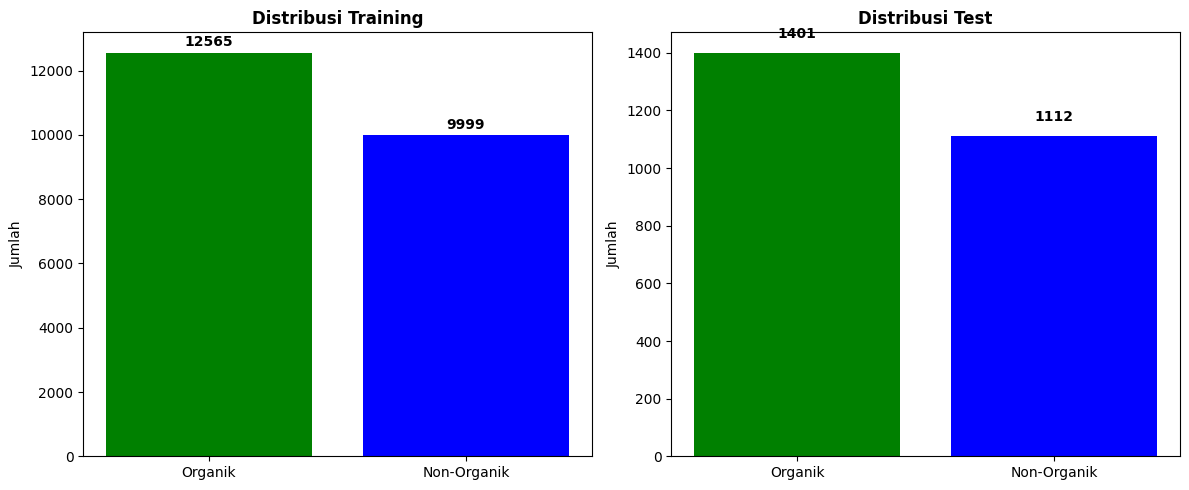

In [2]:
# Path ke dataset
BASE_DIR = Path("dataset_sampah/DATASET")

# Hitung jumlah gambar di setiap folder
train_organic = len(list((BASE_DIR / "TRAIN" / "O").glob('*.jpg')))
train_recyclable = len(list((BASE_DIR / "TRAIN" / "R").glob('*.jpg')))
test_organic = len(list((BASE_DIR / "TEST" / "O").glob('*.jpg')))
test_recyclable = len(list((BASE_DIR / "TEST" / "R").glob('*.jpg')))

print("Jumlah gambar:")
print(f"Training - Organik: {train_organic}")
print(f"Training - Non-organik: {train_recyclable}")
print(f"Test - Organik: {test_organic}")
print(f"Test - Non-organik: {test_recyclable}")
print(f"\nTotal training: {train_organic + train_recyclable}")
print(f"Total test: {test_organic + test_recyclable}")

# Visualisasi distribusi
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training
axes[0].bar(['Organik', 'Non-Organik'], [train_organic, train_recyclable], 
            color=['green', 'blue'])
axes[0].set_title('Distribusi Training', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jumlah')
axes[0].text(0, train_organic + 200, str(train_organic), ha='center', fontweight='bold')
axes[0].text(1, train_recyclable + 200, str(train_recyclable), ha='center', fontweight='bold')

# Test
axes[1].bar(['Organik', 'Non-Organik'], [test_organic, test_recyclable], 
            color=['green', 'blue'])
axes[1].set_title('Distribusi Test', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Jumlah')
axes[1].text(0, test_organic + 50, str(test_organic), ha='center', fontweight='bold')
axes[1].text(1, test_recyclable + 50, str(test_recyclable), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


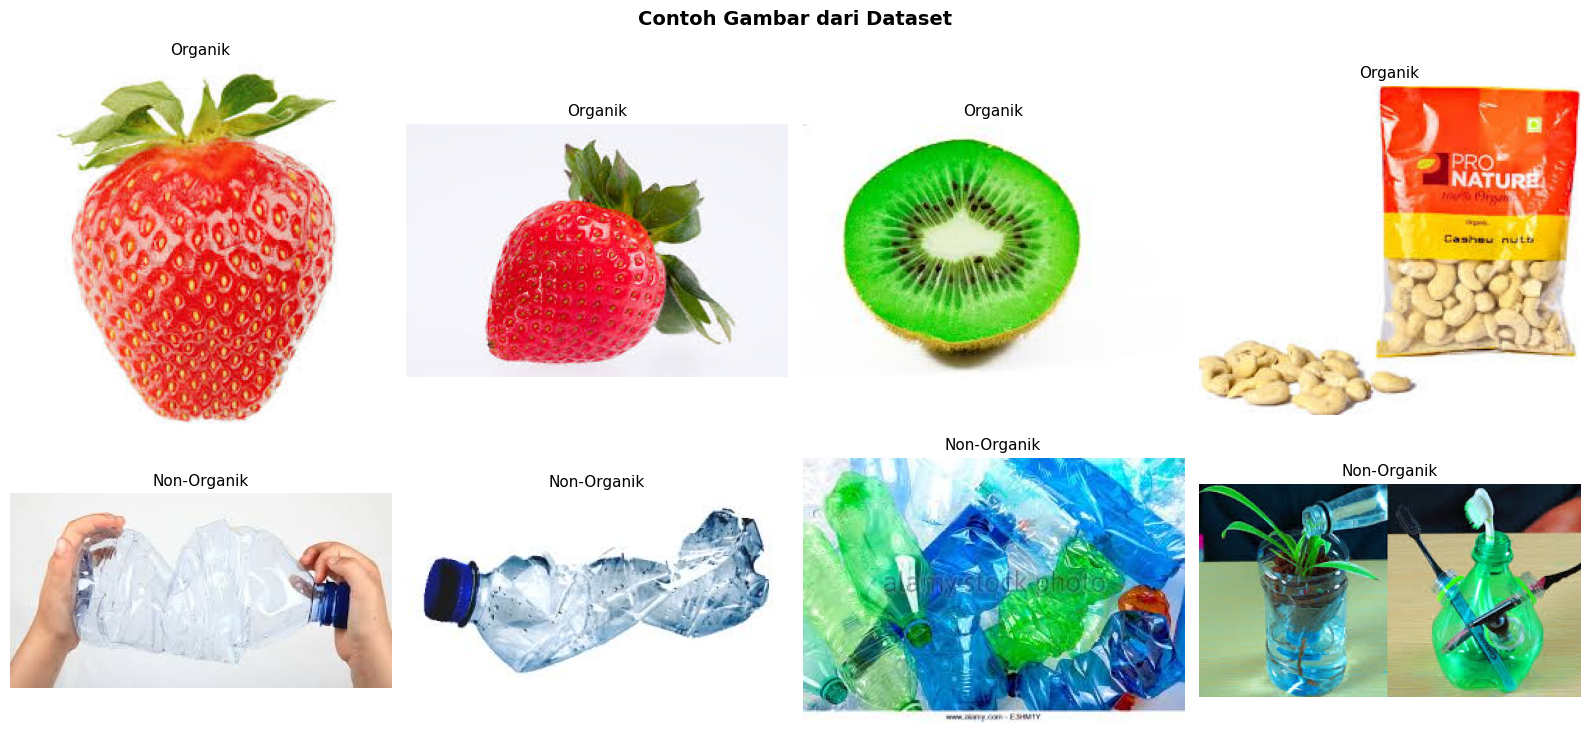

In [3]:
# Lihat beberapa contoh gambar
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Gambar organik
organic_paths = list((BASE_DIR / "TRAIN" / "O").glob('*.jpg'))[:4]
for i, path in enumerate(organic_paths):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title('Organik', fontsize=11)
    axes[0, i].axis('off')

# Gambar non-organik
recyclable_paths = list((BASE_DIR / "TRAIN" / "R").glob('*.jpg'))[:4]
for i, path in enumerate(recyclable_paths):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title('Non-Organik', fontsize=11)
    axes[1, i].axis('off')

plt.suptitle('Contoh Gambar dari Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. Preprocessing

### Konfigurasi Preprocessing

1. **Resize gambar**: Menyamakan ukuran semua gambar menjadi 224x224 (ukuran standar untuk transfer learning)
2. **Normalisasi**: Mengubah nilai pixel dari [0, 255] menjadi [0, 1]
3. **Data Augmentation**: Meningkatkan variasi data untuk meningkatkan generalisasi model
4. **Penanganan Imbalanced Data**: Menggunakan class weights untuk menyeimbangkan data yang tidak seimbang antara kelas organik dan non-organik


In [ ]:
# Setting untuk training
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Augmentasi data untuk training (biar model lebih robust)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% untuk validasi
)

# Untuk validasi dan test, cukup normalisasi saja
val_test_datagen = ImageDataGenerator(rescale=1./255)

print(f"Ukuran gambar: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")


Ukuran gambar: 224x224
Batch size: 32
Epochs: 50


### Penanganan Data Tidak Seimbang (Imbalanced Data)

Dataset memiliki distribusi yang tidak seimbang:
- **Organik (O)**: 12,565 gambar (55.7%)
- **Non-organik (R)**: 9,999 gambar (44.3%)

Untuk mengatasi masalah ini, kita menggunakan **Class Weights** yang akan memberikan bobot lebih tinggi pada kelas minoritas (non-organik) selama training. Ini memastikan model belajar dengan baik untuk kedua kelas tanpa bias terhadap kelas mayoritas.


Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.

Training: 18052 gambar
Validasi: 4512 gambar
Test: 2513 gambar

Class weights:
  Organik: 0.718
  Non-organik: 0.903


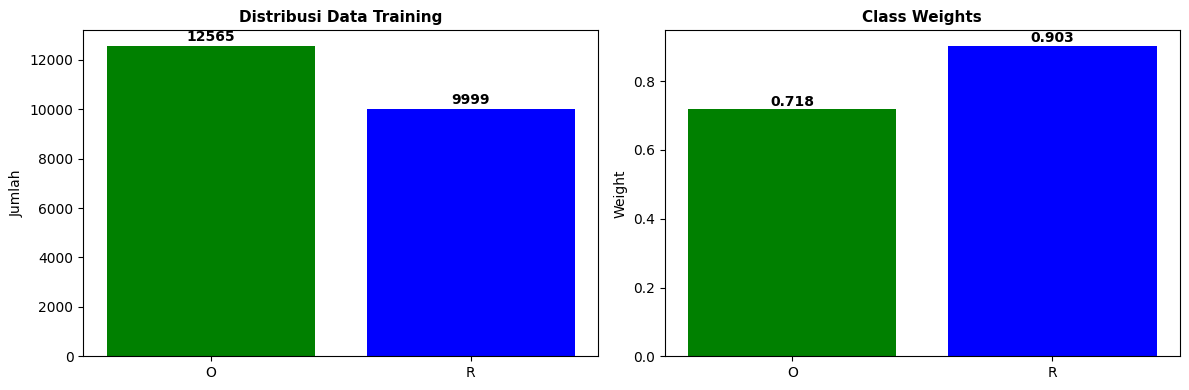

In [ ]:
# Load data
train_generator = train_datagen.flow_from_directory(
    BASE_DIR / "TRAIN",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    BASE_DIR / "TRAIN",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    BASE_DIR / "TEST",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

print(f"\nTraining: {train_generator.samples} gambar")
print(f"Validasi: {validation_generator.samples} gambar")
print(f"Test: {test_generator.samples} gambar")

# Hitung class weights untuk menyeimbangkan data
# Data kita tidak seimbang: organik lebih banyak dari non-organik
total = train_generator.samples
organik_count = train_organic
nonorganik_count = train_recyclable

# Hitung weight (kelas yang lebih sedikit dapat weight lebih besar)
weight_organik = total / (2 * organik_count)
weight_nonorganik = total / (2 * nonorganik_count)

class_weight = {
    0: weight_organik,      # Organik
    1: weight_nonorganik    # Non-organik
}

print(f"\nClass weights:")
print(f"  Organik: {weight_organik:.3f}")
print(f"  Non-organik: {weight_nonorganik:.3f}")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribusi data
axes[0].bar(['O', 'R'], [organik_count, nonorganik_count], color=['green', 'blue'])
axes[0].set_title('Distribusi Data Training', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Jumlah')
axes[0].text(0, organik_count + 200, f'{organik_count}', ha='center', fontweight='bold')
axes[0].text(1, nonorganik_count + 200, f'{nonorganik_count}', ha='center', fontweight='bold')

# Class weights
axes[1].bar(['O', 'R'], [weight_organik, weight_nonorganik], color=['green', 'blue'])
axes[1].set_title('Class Weights', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Weight')
axes[1].text(0, weight_organik + 0.01, f'{weight_organik:.3f}', ha='center', fontweight='bold')
axes[1].text(1, weight_nonorganik + 0.01, f'{weight_nonorganik:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 4. Membangun Model CNN

Kita akan menggunakan **Transfer Learning** dengan **MobileNetV2** untuk mencapai akurasi >90%. MobileNetV2 adalah arsitektur yang efisien dan stabil untuk klasifikasi gambar.

### Arsitektur Model:
1. **Base Model**: MobileNetV2 (pre-trained on ImageNet)
2. **Global Average Pooling**: Mengurangi overfitting
3. **Dense Layers**: Dengan Batch Normalization dan Dropout
4. **Output Layer**: Sigmoid activation untuk binary classification


In [ ]:
# Buat model menggunakan MobileNetV2 (lebih stabil di Keras 3.x)
# MobileNetV2 juga bagus untuk transfer learning dan lebih ringan
from tensorflow.keras.applications import MobileNetV2

input_tensor = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=input_tensor,
    pooling=None
)

# Freeze sebagian layer, unfreeze layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Tambahkan layer untuk klasifikasi
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)  # Output: 0 = organik, 1 = non-organik

model = models.Model(inputs=input_tensor, outputs=output)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,052,609 (11.64 MB)

 Trainable params: 2,317,441 (8.84 MB)

 Non-trainable params: 735,168 (2.80 MB)

In [ ]:
# Model sudah dibuat, siap untuk training
print("Model siap digunakan!")


Model siap digunakan!


## 5. Training Model


In [8]:
# Setup callbacks untuk optimasi training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]


In [9]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train model dengan class_weight untuk menangani imbalanced data
print("\nStarting training...")
print("⚠️ Menggunakan class_weight untuk menyeimbangkan data yang tidak seimbang")
print(f"   Class weights: {class_weight}")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight,  # Menambahkan class_weight untuk balancing
    verbose=1
)

print("\nTraining completed!")


Steps per epoch: 564
Validation steps: 141

Starting training...
⚠️ Menggunakan class_weight untuk menyeimbangkan data yang tidak seimbang
   Class weights: {0: 0.7183446080382013, 1: 0.9026902690269026}
Epoch 1/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.8708 - loss: 0.2537 - precision: 0.8350 - recall: 0.8806
Epoch 1: val_accuracy improved from None to 0.89960, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 589s 1s/step - accuracy: 0.8961 - loss: 0.2092 - precision: 0.8659 - recall: 0.9060 - val_accuracy: 0.8996 - val_loss: 0.8053 - val_precision: 0.8289 - val_recall: 0.9745 - learning_rate: 0.0010
Epoch 2/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 2:55 312ms/step - accuracy: 0.9688 - loss: 0.0790 - precision: 0.9286 - recall: 1.0000
Epoch 2: val_accuracy improved from 0.89960 to 0.90182, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 0.9688 - loss: 0.0790 - precision: 0.9286 - recall: 1.0000 - val_accuracy: 0.9018 - val_loss: 0.7951 - val_precision: 0.8313 - val_recall: 0.9765 - learning_rate: 0.0010
Epoch 3/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9267 - loss: 0.1559 - precision: 0.8998 - recall: 0.9375
Epoch 3: val_accuracy improved from 0.90182 to 0.91356, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 352s 624ms/step - accuracy: 0.9269 - loss: 0.1549 - precision: 0.9022 - recall: 0.9365 - val_accuracy: 0.9136 - val_loss: 0.5687 - val_precision: 0.8549 - val_recall: 0.9695 - learning_rate: 0.0010
Epoch 4/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 2:48 299ms/step - accuracy: 0.9375 - loss: 0.2375 - precision: 1.0000 - recall: 0.8667
Epoch 4: val_accuracy improved from 0.91356 to 0.91423, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 0.9375 - loss: 0.2375 - precision: 1.0000 - recall: 0.8667 - val_accuracy: 0.9142 - val_loss: 0.5388 - val_precision: 0.8592 - val_recall: 0.9645 - learning_rate: 0.0010
Epoch 5/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.9412 - loss: 0.1269 - precision: 0.9181 - recall: 0.9512
Epoch 5: val_accuracy improved from 0.91423 to 0.92354, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 355s 629ms/step - accuracy: 0.9414 - loss: 0.1275 - precision: 0.9213 - recall: 0.9488 - val_accuracy: 0.9235 - val_loss: 0.3970 - val_precision: 0.8946 - val_recall: 0.9380 - learning_rate: 0.0010
Epoch 6/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 2:55 311ms/step - accuracy: 0.9688 - loss: 0.1380 - precision: 1.0000 - recall: 0.9444
Epoch 6: val_accuracy did not improve from 0.92354
564/564 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 0.9688 - loss: 0.1380 - precision: 1.0000 - recall: 0.9444 - val_accuracy: 0.9231 - val_loss: 0.4012 - val_precision: 0.8975 - val_recall: 0.9330 - learning_rate: 0.0010
Epoch 7/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9498 - loss: 0.1094 - precision: 0.9330 - recall: 0.9559
Epoch 7: val_accuracy improved from 0.92354 to 0.92686, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 357s 634ms/step - accuracy: 0.9454 - loss: 0.1193 - precision: 0.9267 - recall: 0.9522 - val_accuracy: 0.9269 - val_loss: 0.3777 - val_precision: 0.8972 - val_recall: 0.9430 - learning_rate: 0.0010
Epoch 8/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 2:48 299ms/step - accuracy: 0.8125 - loss: 0.2919 - precision: 0.6667 - recall: 0.9091
Epoch 8: val_accuracy did not improve from 0.92686
564/564 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 0.8125 - loss: 0.2919 - precision: 0.6667 - recall: 0.9091 - val_accuracy: 0.9266 - val_loss: 0.4196 - val_precision: 0.8971 - val_recall: 0.9425 - learning_rate: 0.0010
Epoch 9/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9445 - loss: 0.1130 - precision: 0.9214 - recall: 0.9565
Epoch 9: val_accuracy improved from 0.92686 to 0.92996, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 351s 622ms/step - accuracy: 0.9467 - loss: 0.1097 - precision: 0.9280 - recall: 0.9538 - val_accuracy: 0.9300 - val_loss: 0.3245 - val_precision: 0.9123 - val_recall: 0.9315 - learning_rate: 0.0010
Epoch 10/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 2:47 298ms/step - accuracy: 0.9375 - loss: 0.0655 - precision: 0.8750 - recall: 1.0000
Epoch 10: val_accuracy improved from 0.92996 to 0.93262, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - accuracy: 0.9375 - loss: 0.0655 - precision: 0.8750 - recall: 1.0000 - val_accuracy: 0.9326 - val_loss: 0.3020 - val_precision: 0.9181 - val_recall: 0.9310 - learning_rate: 0.0010
Epoch 11/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9554 - loss: 0.0966 - precision: 0.9421 - recall: 0.9582
Epoch 11: val_accuracy did not improve from 0.93262
564/564 ━━━━━━━━━━━━━━━━━━━━ 551s 977ms/step - accuracy: 0.9541 - loss: 0.1003 - precision: 0.9404 - recall: 0.9569 - val_accuracy: 0.9315 - val_loss: 0.3084 - val_precision: 0.9255 - val_recall: 0.9195 - learning_rate: 0.0010
Epoch 12/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 2:51 305ms/step - accuracy: 0.9375 - loss: 0.0778 - precision: 1.0000 - recall: 0.8667
Epoch 12: val_accuracy improved from 0.93262 to 0.93661, saving model to best_model.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 0.9375 - loss: 0.0778 - precision: 1.0000 - recall: 0.8667 - val_accuracy: 0.9366 - val_loss: 0.2999 - val_precision: 0.9289 - val_recall: 0.9280 - learning_rate: 0.0010
Epoch 13/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9548 - loss: 0.0951 - precision: 0.9392 - recall: 0.9604
Epoch 13: val_accuracy did not improve from 0.93661
564/564 ━━━━━━━━━━━━━━━━━━━━ 382s 677ms/step - accuracy: 0.9547 - loss: 0.0966 - precision: 0.9429 - recall: 0.9557 - val_accuracy: 0.9178 - val_loss: 0.4616 - val_precision: 0.9391 - val_recall: 0.8709 - learning_rate: 0.0010
Epoch 14/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 2:50 303ms/step - accuracy: 0.9688 - loss: 0.0672 - precision: 0.9286 - recall: 1.0000
Epoch 14: val_accuracy did not improve from 0.93661
564/564 ━━━━━━━━━━━━━━━━━━━━ 65s 115ms/step - accuracy: 0.9688 - loss: 0.0672 - precision: 0.9286 - recall: 1.0000 - val_accuracy: 0.9202 - val_loss: 0.4542 - val_precision: 0.9380 - val_re

564/564 ━━━━━━━━━━━━━━━━━━━━ 352s 624ms/step - accuracy: 0.9740 - loss: 0.0568 - precision: 0.9653 - recall: 0.9764 - val_accuracy: 0.9371 - val_loss: 0.2519 - val_precision: 0.9307 - val_recall: 0.9270 - learning_rate: 5.0000e-04
Epoch 20/50
  1/564 ━━━━━━━━━━━━━━━━━━━━ 3:06 331ms/step - accuracy: 0.9375 - loss: 0.0905 - precision: 1.0000 - recall: 0.8889
Epoch 20: val_accuracy did not improve from 0.93706
564/564 ━━━━━━━━━━━━━━━━━━━━ 64s 113ms/step - accuracy: 0.9375 - loss: 0.0905 - precision: 1.0000 - recall: 0.8889 - val_accuracy: 0.9335 - val_loss: 0.2672 - val_precision: 0.9280 - val_recall: 0.9215 - learning_rate: 5.0000e-04
Epoch 21/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9809 - loss: 0.0442 - precision: 0.9757 - recall: 0.9812
Epoch 21: val_accuracy did not improve from 0.93706
564/564 ━━━━━━━━━━━━━━━━━━━━ 352s 624ms/step - accuracy: 0.9799 - loss: 0.0448 - precision: 0.9735 - recall: 0.9813 - val_accuracy: 0.9120 - val_loss: 0.3148 - val_precision: 0.8651

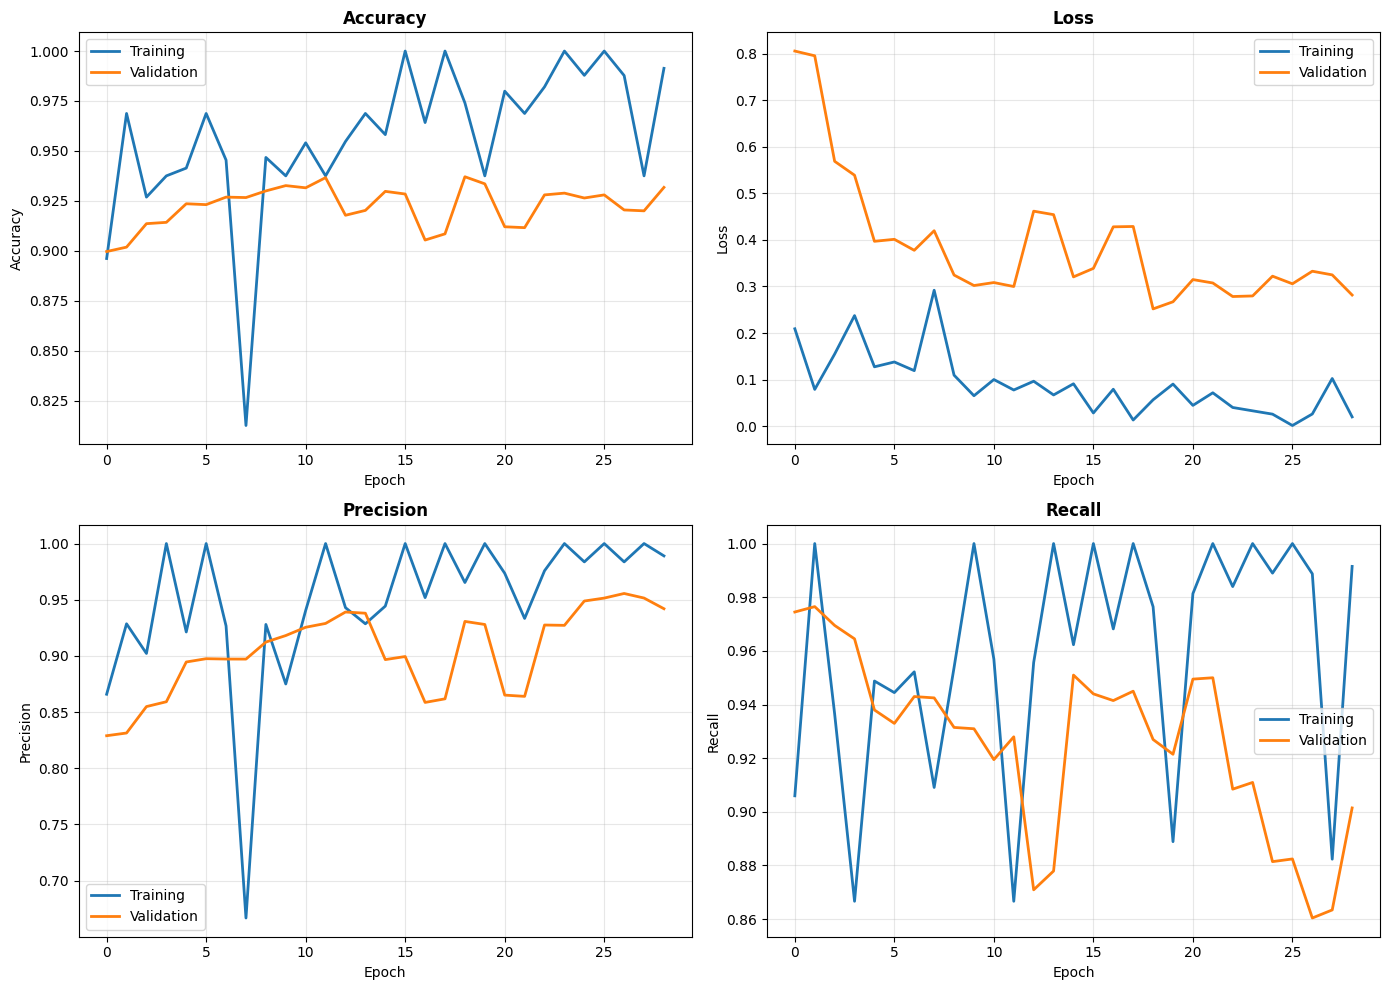


Hasil Training:
Training Accuracy: 0.9913
Validation Accuracy: 0.9317
Training Loss: 0.0201
Validation Loss: 0.2816


In [10]:
# Plot hasil training
# Pastikan training sudah dijalankan terlebih dahulu

if 'history' not in globals():
    print("⚠️ Training belum dijalankan!")
    print("Untuk melihat plot hasil training, jalankan cell training terlebih dahulu (Cell 18).")
    print("Atau jika sudah training sebelumnya, pastikan variabel 'history' tersedia.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)     
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)                                                                               
    axes[0, 0].set_title('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)   
    axes[0, 1].set_title('Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision (kalau ada)
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training', linewidth=2)
        axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)                                                                          
        axes[1, 0].set_title('Precision', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Recall (kalau ada)
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training', linewidth=2)   
        axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)                                                                             
        axes[1, 1].set_title('Recall', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # Tampilkan hasil akhir
    print("\nHasil Training:")
    print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")


## 6. Evaluasi Model

Mengevaluasi model menggunakan dataset test yang belum pernah dilihat selama training.


In [11]:
# Load model terbaik
# Pastikan model dan test_generator sudah didefinisikan

if 'model' not in globals():
    print("❌ Error: Model belum didefinisikan!")
    print("Jalankan cell Quick Start (Cell 4) atau cell training terlebih dahulu.")
elif 'test_generator' not in globals():
    print("❌ Error: test_generator belum didefinisikan!") 
    print("Jalankan cell preprocessing (Cell 11) untuk membuat test_generator.")
    print("Atau jika hanya ingin menggunakan model, skip cell evaluasi ini.")
else:
    try:
        model.load_weights('best_model.h5')
        print("✅ Model terbaik dimuat")
    except:
        print("⚠️ Menggunakan model saat ini (best_model.h5 tidak ditemukan)")
    
    # Evaluasi di test set
    print("\nEvaluasi di test set...")
    test_results = model.evaluate(test_generator, verbose=1)

    print("\nHasil Test:")
    print(f"Loss: {test_results[0]:.4f}")
    print(f"Accuracy: {test_results[1]:.4f}")
    if len(test_results) > 2:
        print(f"Precision: {test_results[2]:.4f}")
        print(f"Recall: {test_results[3]:.4f}")
    
    # Cek apakah target tercapai
    if test_results[1] >= 0.90:
        print(f"\n✅ Target 90% tercapai! Akurasi: {test_results[1]*100:.2f}%")
    else:
        print(f"\n⚠️ Target 90% belum tercapai. Akurasi: {test_results[1]*100:.2f}%")


✅ Model terbaik dimuat

Evaluasi di test set...
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 484ms/step - accuracy: 0.9304 - loss: 0.2582 - precision: 0.9483 - recall: 0.8912

Hasil Test:
Loss: 0.2582
Accuracy: 0.9304
Precision: 0.9483
Recall: 0.8912

✅ Target 90% tercapai! Akurasi: 93.04%


In [12]:
# Prediksi di test set
# Pastikan model dan test_generator sudah didefinisikan

if 'model' not in globals() or 'test_generator' not in globals():
    print("❌ Error: Model atau test_generator belum didefinisikan!")
    print("Jalankan cell evaluasi sebelumnya (Cell 21) terlebih dahulu.")
else:
    print("Membuat prediksi...")
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    
    true_classes = test_generator.classes

    # Classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(true_classes, predicted_classes,
                              target_names=['Organik', 'Non-Organik']))
    
    f1 = f1_score(true_classes, predicted_classes)
    print(f"F1-Score: {f1:.4f}")


Membuat prediksi...
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Organik       0.92      0.96      0.94      1401
 Non-Organik       0.95      0.89      0.92      1112

    accuracy                           0.93      2513
   macro avg       0.93      0.93      0.93      2513
weighted avg       0.93      0.93      0.93      2513

F1-Score: 0.9189


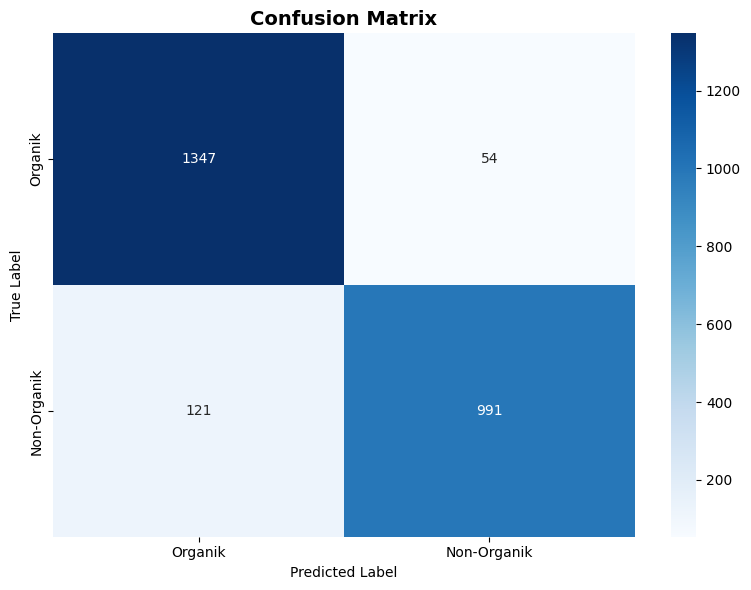


Detail Metrics:
TP: 991, TN: 1347, FP: 54, FN: 121
Accuracy: 0.9304 (93.04%)
Precision: 0.9483 (94.83%)
Recall: 0.8912 (89.12%)
Specificity: 0.9615 (96.15%)


In [13]:
# Confusion Matrix
# Pastikan variabel sudah didefinisikan

if 'true_classes' not in globals() or 'predicted_classes' not in globals():
    print("❌ Error: true_classes atau predicted_classes belum didefinisikan!")
    print("Jalankan cell prediksi sebelumnya (Cell 22) terlebih dahulu.")
else:
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Organik', 'Non-Organik'],
                yticklabels=['Organik', 'Non-Organik'])
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Hitung metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print("\nDetail Metrics:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")


### Visualisasi Sample Prediksi Model

Menampilkan beberapa contoh prediksi model pada gambar test dengan visualisasi yang informatif.


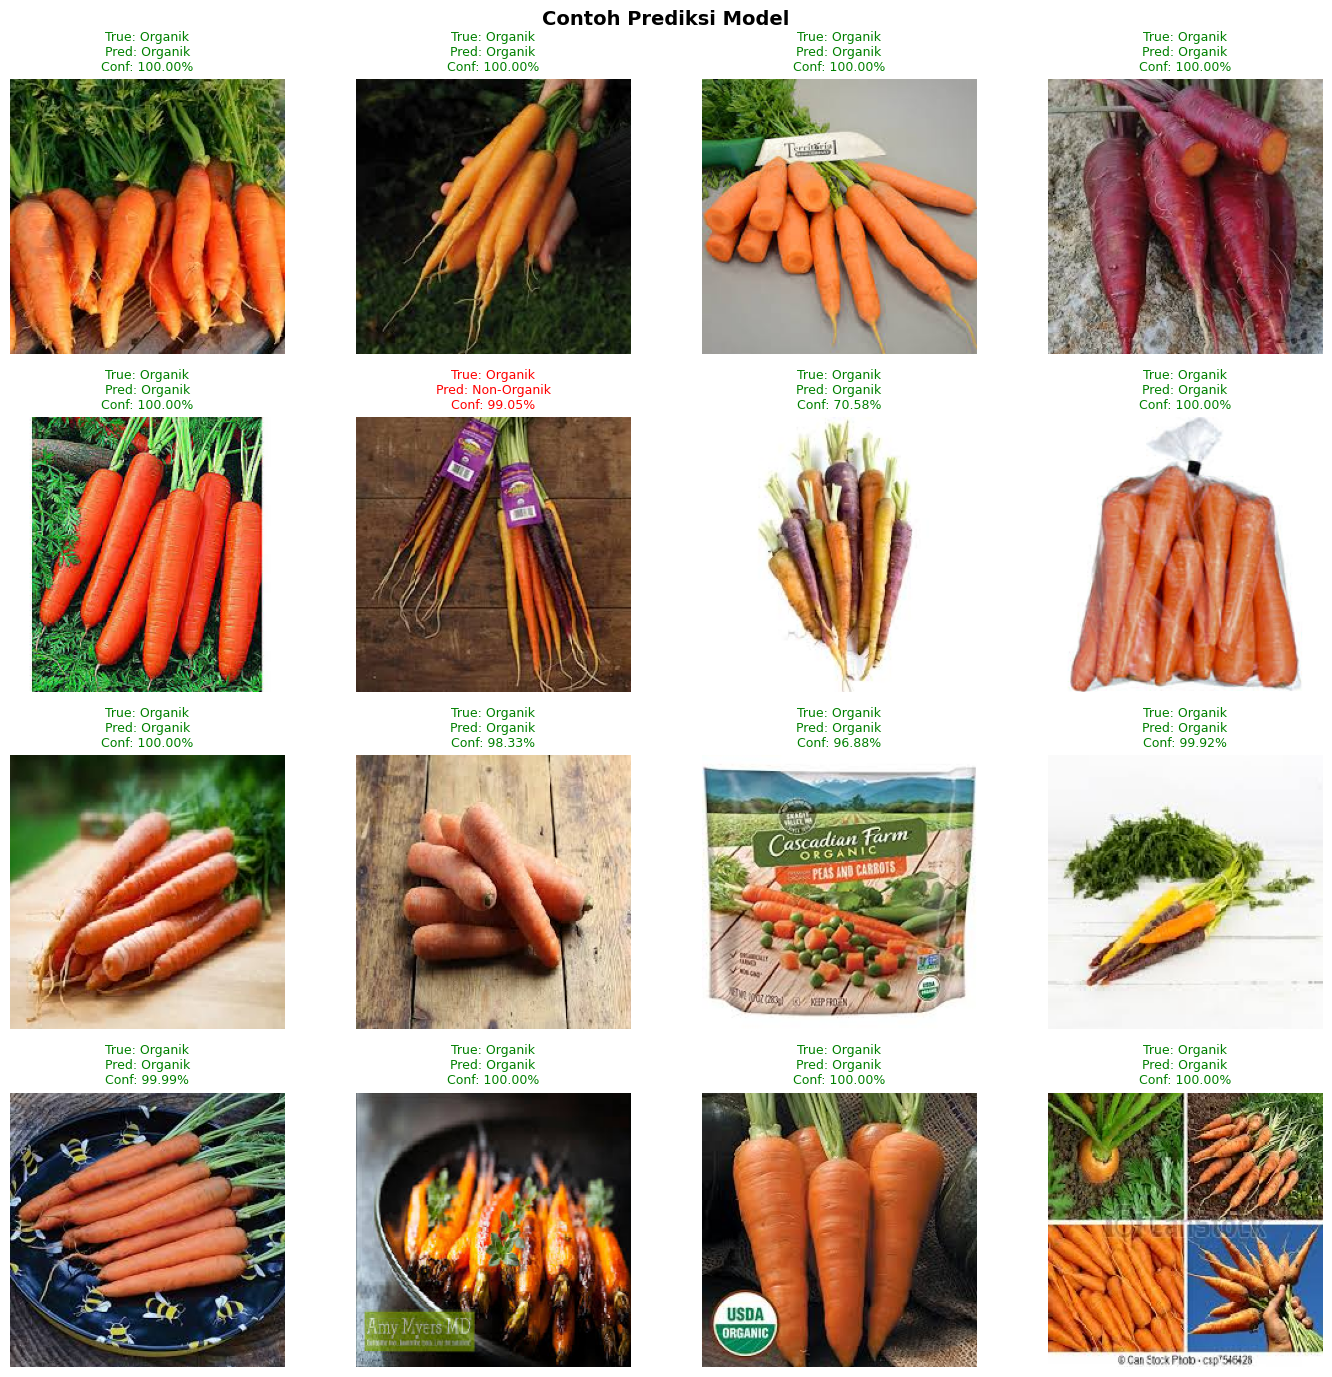

In [26]:
# Lihat beberapa contoh prediksi
# Pastikan model dan test_generator sudah didefinisikan

if 'model' not in globals() or 'test_generator' not in globals():
    print("❌ Error: Model atau test_generator belum didefinisikan!")
    print("Jalankan cell evaluasi sebelumnya terlebih dahulu.")
else:
    test_generator.reset()
    images, labels = next(test_generator)
    preds = model.predict(images, verbose=0)
    pred_classes = (preds > 0.5).astype(int).flatten()

    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.ravel()
    
    class_names = ['Organik', 'Non-Organik']

    for i in range(16):
        img = images[i]
        true_label = class_names[int(labels[i])]
        pred_label = class_names[pred_classes[i]]
        conf = preds[i][0] if pred_classes[i] == 1 else 1 - preds[i][0]
        
        color = 'green' if true_label == pred_label else 'red'
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2%}',                                                                              
                         color=color, fontsize=9)
        axes[i].axis('off')
    
    plt.suptitle('Contoh Prediksi Model', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


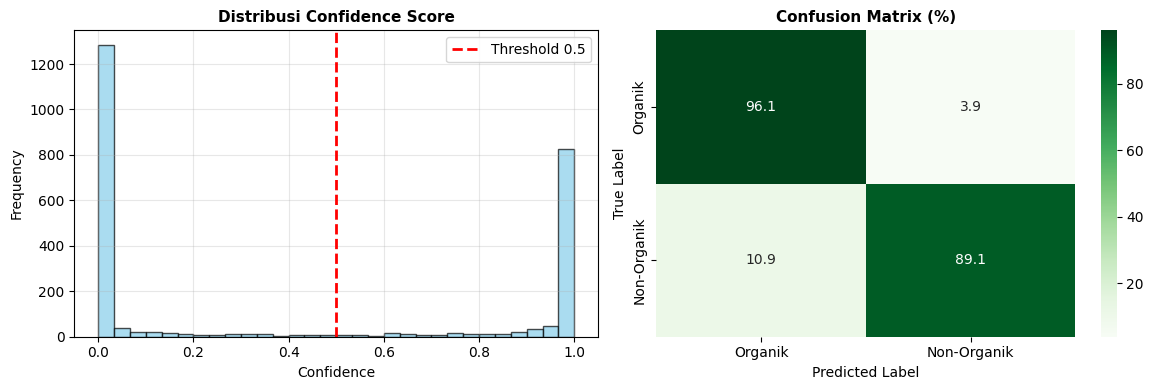

In [15]:
# Analisis distribusi confidence dan confusion matrix persentase
# Pastikan variabel sudah didefinisikan

if 'predictions' not in globals() or 'cm' not in globals():
    print("❌ Error: predictions atau cm belum didefinisikan!")
    print("Jalankan cell evaluasi sebelumnya (Cell 22-23) terlebih dahulu.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram confidence
    axes[0].hist(predictions.flatten(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)                                                                     
    axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold 0.5')                                                                         
    axes[0].set_title('Distribusi Confidence Score', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Confusion matrix persentase
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=['Organik', 'Non-Organik'],
                yticklabels=['Organik', 'Non-Organik'])
    axes[1].set_title('Confusion Matrix (%)', fontsize=11, fontweight='bold')       
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()


## 7. Kesimpulan

Evaluasi model dan kesimpulan project akan ditampilkan di cell berikut.


In [16]:
# Ringkasan hasil evaluasi
# Pastikan evaluasi sudah dijalankan terlebih dahulu

if 'test_results' in globals():
    test_accuracy = test_results[1] * 100
    target_met = test_accuracy >= 90
    
    print("\n" + "="*50)
    print("HASIL EVALUASI")
    print("="*50)
    
    print(f"\nAkurasi Test: {test_accuracy:.2f}%")
    if target_met:
        print("✅ Target 90% tercapai!")
    else:
        print("⚠️ Target 90% belum tercapai")
    
    print(f"\nRingkasan Metrics:")
    print(f"  Accuracy: {test_accuracy:.2f}%")
    
    # Cek variabel metrics lainnya
    if 'precision' in globals():
        print(f"  Precision: {precision*100:.2f}%")
    if 'recall' in globals():
        print(f"  Recall: {recall*100:.2f}%")
    if 'f1' in globals():
        print(f"  F1-Score: {f1*100:.2f}%")
    
    print("\n" + "="*50)
else:
    print("\n" + "="*50)
    print("⚠️ EVALUASI BELUM DILAKUKAN")
    print("="*50)
    print("\nUntuk melihat hasil evaluasi, jalankan cell evaluasi terlebih dahulu:")
    print("  1. Cell 20: Bagian 6 - Evaluasi Model")
    print("  2. Cell 21: Load model terbaik dan evaluasi di test set")
    print("  3. Cell 22-23: Prediksi dan Confusion Matrix")
    print("\nAtau jika sudah training sebelumnya, pastikan cell evaluasi sudah dijalankan.")
    print("="*50)
    print("\nINFO MODEL")
    print("="*50)
    print(f"Model: MobileNetV2 (Transfer Learning)")
    
    # Cek apakah generator sudah didefinisikan
    if 'train_generator' in globals():
        print(f"Training: {train_generator.samples} gambar")
    if 'validation_generator' in globals():
        print(f"Validasi: {validation_generator.samples} gambar")
    if 'test_generator' in globals():
        print(f"Test: {test_generator.samples} gambar")
    
    if 'test_accuracy' in locals():
        print(f"Akurasi: {test_accuracy:.2f}%")
    print("="*50)
    
    print("\nLanjut ke bagian 8 untuk menggunakan fitur deteksi realtime.")



HASIL EVALUASI

Akurasi Test: 93.04%
✅ Target 90% tercapai!

Ringkasan Metrics:
  Accuracy: 93.04%
  Precision: 94.83%
  Recall: 89.12%
  F1-Score: 91.89%



### Deteksi Realtime dengan YOLO dan Bounding Box 🎯

Fitur deteksi realtime menggunakan YOLO untuk object detection dengan bounding box, kemudian mengklasifikasikan objek yang terdeteksi sebagai organik atau non-organik menggunakan model klasifikasi yang sudah ditraining.

**Keuntungan menggunakan YOLO:**
- ✅ Deteksi objek dengan bounding box yang akurat
- ✅ Dapat mendeteksi multiple objek dalam satu frame
- ✅ Visualisasi yang lebih jelas dengan kotak pembatas
- ✅ Kombinasi object detection (YOLO) + classification (model custom)

**Catatan:** 
- YOLO akan download model otomatis saat pertama kali digunakan (sekitar 6MB)
- Jika YOLO belum terinstall, jalankan: `pip install ultralytics`


## 8. Deteksi Realtime menggunakan Webcam

Fitur untuk melakukan deteksi sampah secara realtime menggunakan webcam. Model akan melakukan prediksi pada setiap frame dari video webcam.

**Catatan Penting:**
- Pastikan semua cell sebelumnya sudah dijalankan (terutama training model)
- Model harus sudah dimuat atau tersimpan sebagai `waste_classification_model.h5` atau `best_model.h5`
- Variabel `IMG_SIZE` harus sudah didefinisikan (224)
- Webcam harus terhubung ke komputer

**Instalasi YOLO (untuk fitur bounding box):**
```bash
pip install ultralytics
```
YOLO akan otomatis download model saat pertama kali digunakan (~6MB untuk YOLOv8n).


In [17]:
# Fungsi untuk deteksi realtime menggunakan webcam dengan YOLO dan Bounding Box
def realtime_detection_yolo(classification_model=None, yolo_model=None, camera_index=0, 
                            yolo_conf=0.25, classification_conf=0.5):
    """
    Deteksi sampah secara realtime menggunakan YOLO untuk bounding box
    dan model klasifikasi untuk menentukan organik/non-organik
    
    Parameters:
    - classification_model: Model klasifikasi yang sudah ditraining (opsional)
    - yolo_model: Model YOLO (opsional, akan load YOLOv8n jika None)
    - camera_index: Index kamera (0 untuk webcam default)
    - yolo_conf: Confidence threshold untuk YOLO detection (0.0 - 1.0)
    - classification_conf: Confidence threshold untuk klasifikasi (0.0 - 1.0)
    """
    
    # Cek apakah YOLO tersedia
    if not YOLO_AVAILABLE:
        print("❌ Error: YOLO tidak tersedia!")
        print("Install dengan: pip install ultralytics")
        return
    
    # Pastikan IMG_SIZE sudah didefinisikan
    img_size = 224  # Default
    if 'IMG_SIZE' in globals():
        img_size = IMG_SIZE
    else:
        print("Warning: IMG_SIZE tidak ditemukan, menggunakan default 224")
    
    # Load YOLO model
    if yolo_model is None:
        try:
            print("Loading YOLO model (YOLOv8n)...")
            yolo_model = YOLO('yolov8n.pt')  # Nano model, cepat dan ringan
            print("✅ YOLO model loaded!")
        except Exception as e:
            print(f"❌ Error loading YOLO model: {e}")
            print("YOLO akan download model otomatis saat pertama kali digunakan")
            yolo_model = YOLO('yolov8n.pt')
    
    # Load classification model jika belum dimuat
    if classification_model is None:
        try:
            classification_model = keras.models.load_model('waste_classification_model.h5')
            print("✅ Classification model loaded dari 'waste_classification_model.h5'!")
        except:
            try:
                classification_model = keras.models.load_model('best_model.h5')
                print("✅ Classification model loaded dari 'best_model.h5'!")
            except:
                print("❌ Error: Classification model tidak ditemukan!")
                print("Pastikan file 'waste_classification_model.h5' atau 'best_model.h5' ada")
                return
    
    # Buka webcam
    cap = cv2.VideoCapture(camera_index)
    
    if not cap.isOpened():
        print("❌ Error: Tidak bisa membuka webcam")
        return
    
    print("\n" + "="*60)
    print("DETEKSI REALTIME DENGAN YOLO + BOUNDING BOX")
    print("="*60)
    print("Kontrol:")
    print("  'q' - Keluar")
    print("  's' - Screenshot")
    print("="*60 + "\n")
    
    frame_count = 0
    fps_time = time.time()
    fps = 0
    
    # Warna untuk setiap kelas
    colors = {
        'Organik': (0, 255, 0),      # Hijau
        'Non-Organik': (255, 0, 0)    # Merah (BGR format)
    }
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Tidak bisa membaca frame dari webcam")
            break
        
        # Flip frame secara horizontal (mirror effect)
        frame = cv2.flip(frame, 1)
        display_frame = frame.copy()
        
        # Deteksi objek dengan YOLO
        results = yolo_model(frame, conf=yolo_conf, verbose=False)
        
        # Proses setiap deteksi
        for result in results:
            boxes = result.boxes
            if boxes is not None and len(boxes) > 0:
                for box in boxes:
                    # Ambil koordinat bounding box
                    try:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    except:
                        continue
                
                    # Pastikan koordinat valid
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(frame.shape[1], x2)
                    y2 = min(frame.shape[0], y2)
                    
                    # Crop area yang terdeteksi
                    if x2 > x1 and y2 > y1:
                        roi = frame[y1:y2, x1:x2]
                        
                        if roi.size > 0:
                            # Resize untuk klasifikasi
                            roi_resized = cv2.resize(roi, (img_size, img_size))
                            roi_array = roi_resized.astype('float32') / 255.0
                            roi_array = np.expand_dims(roi_array, axis=0)
                            
                            # Klasifikasi dengan model
                            prediction = classification_model.predict(roi_array, verbose=0)
                            confidence = float(prediction[0][0])
                            
                            # Tentukan kelas
                            if confidence > 0.5:
                                predicted_class = 'Non-Organik'
                                class_confidence = confidence * 100
                            else:
                                predicted_class = 'Organik'
                                class_confidence = (1 - confidence) * 100
                            
                            # Hanya tampilkan jika confidence di atas threshold
                            if class_confidence >= (classification_conf * 100):
                                color = colors[predicted_class]
                                
                                # Gambar bounding box
                                cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 3)
                                
                                # Label dengan background
                                label = f"{predicted_class} {class_confidence:.1f}%"
                                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                                label_y = max(y1 - 10, label_size[1] + 10)
                                
                                # Background untuk label
                                cv2.rectangle(display_frame, 
                                            (x1, label_y - label_size[1] - 5),
                                            (x1 + label_size[0] + 10, label_y + 5),
                                            color, -1)
                                
                                # Text label
                                cv2.putText(display_frame, label,
                                          (x1 + 5, label_y),
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                                          (255, 255, 255), 2)
        
        # Hitung FPS
        frame_count += 1
        if time.time() - fps_time >= 1.0:
            fps = frame_count
            frame_count = 0
            fps_time = time.time()
        
        # Tampilkan FPS
        h, w = frame.shape[:2]
        fps_text = f"FPS: {fps}"
        cv2.putText(display_frame, fps_text, (w - 150, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Tampilkan instruksi
        cv2.putText(display_frame, "Press 'q' to quit, 's' to screenshot",
                   (10, h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # Tampilkan frame
        cv2.imshow('Deteksi Sampah Realtime - YOLO', display_frame)
        
        # Handle keyboard input
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            print("\nDeteksi dihentikan oleh user")
            break
        elif key == ord('s'):
            # Screenshot
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            filename = f"screenshot_yolo_{timestamp}.jpg"
            cv2.imwrite(filename, display_frame)
            print(f"Screenshot disimpan: {filename}")
    
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("\nWebcam ditutup")


# Fungsi untuk deteksi realtime menggunakan webcam (versi original tanpa YOLO)
def realtime_detection(model=None, camera_index=0, confidence_threshold=0.5):
    """
    Deteksi sampah secara realtime menggunakan webcam
    
    Parameters:
    - model: Model yang sudah ditraining (opsional, akan di-load otomatis jika None)
    - camera_index: Index kamera (0 untuk webcam default)
    - confidence_threshold: Threshold confidence untuk menampilkan hasil (0.0 - 1.0)
    """
    
    # Pastikan IMG_SIZE sudah didefinisikan
    # Gunakan variabel lokal untuk menghindari UnboundLocalError
    img_size = 224  # Default
    if 'IMG_SIZE' in globals():
        img_size = IMG_SIZE
    else:
        print("Warning: IMG_SIZE tidak ditemukan, menggunakan default 224")
    
    # Load model jika belum dimuat
    if model is None:
        try:
            model = keras.models.load_model('waste_classification_model.h5')
            print("Model loaded successfully from 'waste_classification_model.h5'!")
        except:
            try:
                model = keras.models.load_model('best_model.h5')
                print("Model loaded from 'best_model.h5'!")
            except:
                print("Error: Model tidak ditemukan!")
                print("Pastikan file 'waste_classification_model.h5' atau 'best_model.h5' ada")
                return
    
    # Buka webcam
    cap = cv2.VideoCapture(camera_index)
    
    if not cap.isOpened():
        print("Error: Tidak bisa membuka webcam")
        return
    
    print("\n" + "="*50)
    print("DETEKSI REALTIME DIMULAI")
    print("="*50)
    print("Tekan 'q' untuk keluar")
    print("Tekan 's' untuk screenshot")
    print("="*50 + "\n")
    
    frame_count = 0
    fps_time = time.time()
    fps = 0
    
    # Warna untuk setiap kelas
    colors = {
        'Organik': (0, 255, 0),      # Hijau
        'Non-Organik': (255, 0, 0)   # Biru (BGR format)
    }
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Tidak bisa membaca frame dari webcam")
            break
        
        # Flip frame secara horizontal (mirror effect)
        frame = cv2.flip(frame, 1)
        
        # Copy frame untuk overlay
        display_frame = frame.copy()
        
        # Resize frame untuk prediksi
        img_resized = cv2.resize(frame, (img_size, img_size))
        
        # Preprocess
        img_array = img_resized.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Prediksi
        prediction = model.predict(img_array, verbose=0)
        confidence = float(prediction[0][0])
        
        # Tentukan kelas
        if confidence > 0.5:
            predicted_class = 'Non-Organik'
            confidence_score = confidence * 100
        else:
            predicted_class = 'Organik'
            confidence_score = (1 - confidence) * 100
        
        # Hanya tampilkan jika confidence di atas threshold
        if confidence_score >= (confidence_threshold * 100):
            # Warna berdasarkan kelas
            color = colors[predicted_class]
            
            # Gambar kotak dan teks
            h, w = frame.shape[:2]
            cv2.rectangle(display_frame, (10, 10), (w-10, 120), color, -1)
            cv2.rectangle(display_frame, (10, 10), (w-10, 120), (255, 255, 255), 2)
            
            # Teks prediksi
            text = f"Kelas: {predicted_class}"
            cv2.putText(display_frame, text, (20, 45), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Teks confidence
            conf_text = f"Confidence: {confidence_score:.1f}%"
            cv2.putText(display_frame, conf_text, (20, 85), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # Hitung FPS
        frame_count += 1
        if time.time() - fps_time >= 1.0:
            fps = frame_count
            frame_count = 0
            fps_time = time.time()
        
        # Tampilkan FPS
        fps_text = f"FPS: {fps}"
        cv2.putText(display_frame, fps_text, (w-150, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Tampilkan instruksi
        cv2.putText(display_frame, "Press 'q' to quit, 's' to screenshot", 
                   (10, h-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # Tampilkan frame
        cv2.imshow('Deteksi Sampah Realtime', display_frame)
        
        # Handle keyboard input
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            print("\nDeteksi dihentikan oleh user")
            break
        elif key == ord('s'):
            # Screenshot
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            filename = f"screenshot_{predicted_class}_{timestamp}.jpg"
            cv2.imwrite(filename, display_frame)
            print(f"Screenshot disimpan: {filename}")
    
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("\nWebcam ditutup")

# Jalankan deteksi realtime
# Uncomment baris di bawah untuk menjalankan

# ⭐ Opsi 1: YOLO dengan Bounding Box (RECOMMENDED) 🎯
realtime_detection_yolo(classification_model=None, yolo_model=None, 
                        camera_index=0, yolo_conf=0.25, classification_conf=0.5)

# Opsi 2: Basic mode tanpa YOLO (tanpa bounding box)
# realtime_detection(model, camera_index=0, confidence_threshold=0.7)


Loading YOLO model (YOLOv8n)...
✅ YOLO model loaded!


✅ Classification model loaded dari 'best_model.h5'!

DETEKSI REALTIME DENGAN YOLO + BOUNDING BOX
Kontrol:
  'q' - Keluar
  's' - Screenshot


Deteksi dihentikan oleh user

Webcam ditutup


### Cara Menggunakan Deteksi Realtime

**Persyaratan:**
1. Pastikan semua cell sebelumnya sudah dijalankan (training model selesai)
2. Model sudah tersimpan sebagai `waste_classification_model.h5` atau `best_model.h5`
3. Webcam terhubung ke komputer

**Langkah-langkah:**
1. Jalankan cell di atas untuk memuat fungsi `realtime_detection()`
2. Uncomment dan jalankan baris terakhir untuk memulai deteksi:
   ```python
   realtime_detection(model, camera_index=0, confidence_threshold=0.7)
   ```
3. Tekan **'q'** untuk keluar dari deteksi
4. Tekan **'s'** untuk mengambil screenshot

**Parameter:**
- `model`: Model yang sudah ditraining (bisa None, akan di-load otomatis)
- `camera_index`: Index kamera (0 = default, 1, 2, dll untuk kamera lain)
- `confidence_threshold`: Batas minimum confidence untuk menampilkan hasil (0.0 - 1.0)


In [18]:
# Versi deteksi realtime dengan fitur tambahan
def realtime_detection_advanced(model=None, camera_index=0, confidence_threshold=0.6, 
                                 show_fps=True, save_screenshots=False):
    """
    Deteksi realtime dengan fitur tambahan
    
    Parameters:
    - model: Model yang sudah ditraining (opsional, akan di-load otomatis jika None)
    - camera_index: Index kamera (0 untuk webcam default)
    - confidence_threshold: Threshold confidence (0.0 - 1.0)
    - show_fps: Tampilkan FPS counter
    - save_screenshots: Auto-save screenshot setiap deteksi (interval 2 detik)
    """
    
    # Pastikan IMG_SIZE sudah didefinisikan
    # Gunakan variabel lokal untuk menghindari UnboundLocalError
    img_size = 224  # Default
    if 'IMG_SIZE' in globals():
        img_size = IMG_SIZE
    else:
        print("Warning: IMG_SIZE tidak ditemukan, menggunakan default 224")
    
    # Load model jika belum dimuat
    if model is None:
        try:
            model = keras.models.load_model('waste_classification_model.h5')
            print("Model loaded successfully from 'waste_classification_model.h5'!")
        except:
            try:
                model = keras.models.load_model('best_model.h5')
                print("Model loaded from 'best_model.h5'!")
            except:
                print("Error: Model tidak ditemukan!")
                print("Pastikan file 'waste_classification_model.h5' atau 'best_model.h5' ada")
                return
    
    cap = cv2.VideoCapture(camera_index)
    
    if not cap.isOpened():
        print("Error: Tidak bisa membuka webcam")
        return
    
    print("\n" + "="*60)
    print("DETEKSI REALTIME - MODE ADVANCED")
    print("="*60)
    print("Kontrol:")
    print("  'q' - Keluar")
    print("  's' - Screenshot manual")
    print("  'c' - Toggle confidence threshold")
    print("  '+' - Increase confidence threshold")
    print("  '-' - Decrease confidence threshold")
    print("="*60 + "\n")
    
    frame_count = 0
    fps_time = time.time()
    fps = 0
    current_threshold = confidence_threshold
    last_save_time = 0
    
    colors = {
        'Organik': (0, 255, 0),
        'Non-Organik': (255, 0, 0)
    }
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        display_frame = frame.copy()
        h, w = frame.shape[:2]
        
        # Resize dan preprocess
        img_resized = cv2.resize(frame, (img_size, img_size))
        img_array = img_resized.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Prediksi
        prediction = model.predict(img_array, verbose=0)
        confidence = float(prediction[0][0])
        
        if confidence > 0.5:
            predicted_class = 'Non-Organik'
            confidence_score = confidence * 100
        else:
            predicted_class = 'Organik'
            confidence_score = (1 - confidence) * 100
        
        # Tampilkan hasil jika di atas threshold
        if confidence_score >= (current_threshold * 100):
            color = colors[predicted_class]
            
            # Background box
            cv2.rectangle(display_frame, (10, 10), (w-10, 140), color, -1)
            cv2.rectangle(display_frame, (10, 10), (w-10, 140), (255, 255, 255), 3)
            
            # Text
            cv2.putText(display_frame, f"Kelas: {predicted_class}", 
                       (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
            cv2.putText(display_frame, f"Confidence: {confidence_score:.1f}%", 
                       (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(display_frame, f"Threshold: {current_threshold*100:.0f}%", 
                       (20, 130), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            # Auto-save screenshot
            if save_screenshots and (time.time() - last_save_time) > 2.0:
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                filename = f"auto_screenshot_{predicted_class}_{confidence_score:.0f}%_{timestamp}.jpg"
                cv2.imwrite(filename, display_frame)
                last_save_time = time.time()
                print(f"Auto-saved: {filename}")
        
        # FPS
        if show_fps:
            frame_count += 1
            if time.time() - fps_time >= 1.0:
                fps = frame_count
                frame_count = 0
                fps_time = time.time()
            
            cv2.putText(display_frame, f"FPS: {fps}", (w-150, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        
        # Instructions
        cv2.putText(display_frame, "q:quit | s:screenshot | +/-:threshold", 
                   (10, h-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        cv2.imshow('Deteksi Sampah Realtime - Advanced', display_frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            break
        elif key == ord('s'):
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            filename = f"screenshot_{predicted_class}_{timestamp}.jpg"
            cv2.imwrite(filename, display_frame)
            print(f"Screenshot: {filename}")
        elif key == ord('+'):
            current_threshold = min(1.0, current_threshold + 0.05)
            print(f"Threshold: {current_threshold*100:.0f}%")
        elif key == ord('-'):
            current_threshold = max(0.0, current_threshold - 0.05)
            print(f"Threshold: {current_threshold*100:.0f}%")
        elif key == ord('c'):
            current_threshold = confidence_threshold
            print(f"Threshold reset: {current_threshold*100:.0f}%")
    
    cap.release()
    cv2.destroyAllWindows()
    print("\nDeteksi selesai!")

# Uncomment untuk menjalankan mode advanced
realtime_detection_advanced(model, camera_index=0, confidence_threshold=0.7, 
                           show_fps=True, save_screenshots=False)



DETEKSI REALTIME - MODE ADVANCED
Kontrol:
  'q' - Keluar
  's' - Screenshot manual
  'c' - Toggle confidence threshold
  '+' - Increase confidence threshold
  '-' - Decrease confidence threshold


Deteksi selesai!


### Deteksi dari Video File

Selain webcam, kita juga bisa melakukan deteksi dari video file yang sudah ada.

**Format video yang didukung:** MP4, AVI, MOV, dll (format yang didukung OpenCV)

**Cara menggunakan:**
1. Siapkan video file (contoh: `video_sampah.mp4`)
2. Jalankan fungsi dengan format:
   ```python
   detect_from_video(model, 'video_sampah.mp4', 'output_video.mp4', confidence_threshold=0.7)
   ```
3. Video hasil akan tersimpan dengan anotasi prediksi


In [19]:
def detect_from_video(model=None, video_path=None, output_path=None, confidence_threshold=0.6):
    """
    Deteksi sampah dari video file
    
    Parameters:
    - model: Model yang sudah ditraining (opsional, akan di-load otomatis jika None)
    - video_path: Path ke video file (contoh: 'video_sampah.mp4')
    - output_path: Path untuk menyimpan video hasil dengan anotasi (opsional)
    - confidence_threshold: Threshold confidence (0.0 - 1.0)
    """
    
    if video_path is None:
        print("Error: video_path harus diisi!")
        print("Contoh: detect_from_video(model, 'video_sampah.mp4')")
        return
    
    # Pastikan IMG_SIZE sudah didefinisikan
    # Gunakan variabel lokal untuk menghindari UnboundLocalError
    img_size = 224  # Default
    if 'IMG_SIZE' in globals():
        img_size = IMG_SIZE
    else:
        print("Warning: IMG_SIZE tidak ditemukan, menggunakan default 224")
    
    # Load model jika belum dimuat
    if model is None:
        try:
            model = keras.models.load_model('waste_classification_model.h5')
            print("Model loaded successfully from 'waste_classification_model.h5'!")
        except:
            try:
                model = keras.models.load_model('best_model.h5')
                print("Model loaded from 'best_model.h5'!")
            except:
                print("Error: Model tidak ditemukan!")
                print("Pastikan file 'waste_classification_model.h5' atau 'best_model.h5' ada")
                return
    
    # Buka video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Tidak bisa membuka video {video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\nVideo Info:")
    print(f"  Resolution: {width}x{height}")
    print(f"  FPS: {fps}")
    print(f"  Total frames: {total_frames}")
    print(f"  Duration: {total_frames/fps:.2f} seconds\n")
    
    # Setup video writer jika output_path diberikan
    writer = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        print(f"Output video akan disimpan ke: {output_path}\n")
    
    colors = {
        'Organik': (0, 255, 0),
        'Non-Organik': (255, 0, 0)
    }
    
    frame_num = 0
    start_time = time.time()
    
    print("Memproses video... (Tekan 'q' untuk skip ke akhir)")
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame_num += 1
        
        # Preprocess
        img_resized = cv2.resize(frame, (img_size, img_size))
        img_array = img_resized.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Prediksi
        prediction = model.predict(img_array, verbose=0)
        confidence = float(prediction[0][0])
        
        if confidence > 0.5:
            predicted_class = 'Non-Organik'
            confidence_score = confidence * 100
        else:
            predicted_class = 'Organik'
            confidence_score = (1 - confidence) * 100
        
        # Tampilkan hasil
        display_frame = frame.copy()
        
        if confidence_score >= (confidence_threshold * 100):
            color = colors[predicted_class]
            
            cv2.rectangle(display_frame, (10, 10), (width-10, 120), color, -1)
            cv2.rectangle(display_frame, (10, 10), (width-10, 120), (255, 255, 255), 2)
            
            cv2.putText(display_frame, f"Kelas: {predicted_class}", 
                       (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(display_frame, f"Confidence: {confidence_score:.1f}%", 
                       (20, 85), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # Progress
        progress = (frame_num / total_frames) * 100
        cv2.putText(display_frame, f"Progress: {progress:.1f}%", 
                   (10, height-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Tampilkan frame
        cv2.imshow('Deteksi dari Video', display_frame)
        
        # Write frame jika output_path diberikan
        if writer:
            writer.write(display_frame)
        
        # Handle keyboard
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            print("\nDibatalkan oleh user")
            break
        
        # Print progress setiap 30 frames
        if frame_num % 30 == 0:
            elapsed = time.time() - start_time
            fps_actual = frame_num / elapsed
            print(f"Frame {frame_num}/{total_frames} ({progress:.1f}%) - FPS: {fps_actual:.1f}")
    
    # Cleanup
    cap.release()
    if writer:
        writer.release()
    cv2.destroyAllWindows()
    
    elapsed = time.time() - start_time
    print(f"\nSelesai! Waktu: {elapsed:.2f} detik")
    print(f"Total frames: {frame_num}")
    if output_path:
        print(f"Video hasil disimpan: {output_path}")

# Contoh penggunaan:
detect_from_video(model, 'video_sampah.mp4', 'output_video.mp4', confidence_threshold=0.7)


Error: Tidak bisa membuka video video_sampah.mp4


### Quick Start - Deteksi Realtime

Cell di bawah ini untuk quick start deteksi realtime. Pastikan model sudah ditraining dan disimpan.


In [12]:
# Quick Start - Deteksi Realtime Webcam
# Uncomment baris di bawah untuk langsung mulai deteksi

# ⭐ Opsi 1: YOLO dengan Bounding Box (RECOMMENDED) 🎯
# realtime_detection_yolo(classification_model=None, yolo_model=None, 
#                        camera_index=0, yolo_conf=0.25, classification_conf=0.5)

# Opsi 2: Basic mode (simple, tanpa YOLO)
# realtime_detection(model=None, camera_index=0, confidence_threshold=0.7)

# Opsi 3: Advanced mode (dengan fitur tambahan, tanpa YOLO)
# realtime_detection_advanced(model=None, camera_index=0, confidence_threshold=0.7, 
#                            show_fps=True, save_screenshots=False)

# Opsi 4: Deteksi dari video file
# detect_from_video(model=None, video_path='video_sampah.mp4', 
#                   output_path='output_video.mp4', confidence_threshold=0.7)

print("Fungsi realtime detection sudah dimuat!")
print("\nPilih salah satu opsi di atas, uncomment dan jalankan.")
print("💡 Rekomendasi: Gunakan Opsi 1 (YOLO) untuk deteksi dengan bounding box!")
print("Pastikan:")
print("  - Model sudah ditraining (waste_classification_model.h5 atau best_model.h5 ada)")
print("  - Webcam terhubung (untuk opsi 1 dan 2)")
print("  - Video file ada (untuk opsi 3)")


Fungsi realtime detection sudah dimuat!

Pilih salah satu opsi di atas, uncomment dan jalankan.
💡 Rekomendasi: Gunakan Opsi 1 (YOLO) untuk deteksi dengan bounding box!
Pastikan:
  - Model sudah ditraining (waste_classification_model.h5 atau best_model.h5 ada)
  - Webcam terhubung (untuk opsi 1 dan 2)
  - Video file ada (untuk opsi 3)


## 9. Kesimpulan dan Simpan Model

Kesimpulan project dan menyimpan model. Cell ini sebaiknya dijalankan di akhir setelah semua fitur realtime digunakan, agar semua perubahan ikut tersimpan.


In [20]:
# Kesimpulan dan Simpan Model
# Cell ini sebaiknya dijalankan di akhir setelah menggunakan fitur realtime detection

print("\n" + "="*60)
print("KESIMPULAN PROJECT")
print("="*60)

# Pastikan variabel evaluasi sudah ada
if 'test_results' in globals():
    test_accuracy = test_results[1] * 100
    target_met = test_accuracy >= 90
    
    print(f"\nAkurasi Test: {test_accuracy:.2f}%")
    if target_met:
        print("✅ Target 90% tercapai!")
    else:
        print("⚠️ Target 90% belum tercapai")
    
    print(f"\nRingkasan Metrics:")
    print(f"  Accuracy: {test_accuracy:.2f}%")
    if 'precision' in globals():
        print(f"  Precision: {precision*100:.2f}%")
    if 'recall' in globals():
        print(f"  Recall: {recall*100:.2f}%")
    if 'f1' in globals():
        print(f"  F1-Score: {f1*100:.2f}%")
else:
    print("\n⚠️ Evaluasi belum dilakukan. Jalankan cell evaluasi terlebih dahulu.")
    test_accuracy = 0

print(f"\nKelebihan Model:")
print("  - Transfer Learning dengan MobileNetV2")
print("  - Data augmentation untuk meningkatkan generalisasi")
print("  - Class weights untuk handle imbalanced data")
print("  - Callbacks untuk optimasi training")

print("\n" + "="*60)
print("FITUR YANG TERSEDIA")
print("="*60)
print("1. ✅ Training dan Evaluasi Model")
print("2. ✅ Deteksi Realtime menggunakan Webcam")
print("3. ✅ Deteksi dari Video File")
print("4. ✅ Screenshot dan Auto-save")
print("5. ✅ Adjustable confidence threshold")
print("6. ✅ FPS monitoring")
print("="*60)

print("\n" + "="*60)
print("SUMMARY PROJECT")
print("="*60)
print(f"Model Architecture: MobileNetV2 (Transfer Learning)")
if 'train_generator' in globals():
    print(f"Training Images: {train_generator.samples}")
    print(f"Validation Images: {validation_generator.samples}")
    print(f"Test Images: {test_generator.samples}")
if 'test_accuracy' in locals() or 'test_accuracy' in globals():
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    if test_accuracy >= 90:
        print("Target Accuracy (90%): ✅ ACHIEVED")
    else:
        print("Target Accuracy (90%): ⚠️ NOT ACHIEVED")
print("="*60)

# Save model (akan menyimpan model terbaru termasuk jika ada perubahan dari realtime)
print("\nMenyimpan model...")
try:
    if 'model' in globals():
        model.save('waste_classification_model.h5')
        print("✅ Model tersimpan sebagai 'waste_classification_model.h5'")
        print("   Model ini siap digunakan untuk deployment dan realtime detection!")
    else:
        print("⚠️ Model tidak ditemukan. Pastikan model sudah dibuat dan ditraining.")
except Exception as e:
    print(f"⚠️ Error saat menyimpan model: {e}")

# Cek file model yang ada
import os
print("\nFile model yang tersedia:")
if os.path.exists('waste_classification_model.h5'):
    size = os.path.getsize('waste_classification_model.h5') / (1024*1024)
    print(f"  ✅ waste_classification_model.h5 ({size:.2f} MB)")
if os.path.exists('best_model.h5'):
    size = os.path.getsize('best_model.h5') / (1024*1024)
    print(f"  ✅ best_model.h5 ({size:.2f} MB)")

print("\n" + "="*60)
print("PROJECT SELESAI! 🎉")
print("="*60)
print("Model sudah siap digunakan untuk:")
print("  - Deployment dengan Flask")
print("  - Deteksi realtime menggunakan webcam")
print("  - Deteksi dari video file")
print("  - Aplikasi mobile (setelah konversi ke TensorFlow Lite)")
print("="*60)



KESIMPULAN PROJECT

Akurasi Test: 93.04%
✅ Target 90% tercapai!

Ringkasan Metrics:
  Accuracy: 93.04%
  Precision: 94.83%
  Recall: 89.12%
  F1-Score: 91.89%

Kelebihan Model:
  - Transfer Learning dengan MobileNetV2
  - Data augmentation untuk meningkatkan generalisasi
  - Class weights untuk handle imbalanced data
  - Callbacks untuk optimasi training

FITUR YANG TERSEDIA
1. ✅ Training dan Evaluasi Model
2. ✅ Deteksi Realtime menggunakan Webcam
3. ✅ Deteksi dari Video File
4. ✅ Screenshot dan Auto-save
5. ✅ Adjustable confidence threshold
6. ✅ FPS monitoring

SUMMARY PROJECT
Model Architecture: MobileNetV2 (Transfer Learning)
Training Images: 18052
Validation Images: 4512
Test Images: 2513
Final Test Accuracy: 93.04%
Target Accuracy (90%): ✅ ACHIEVED

Menyimpan model...
✅ Model tersimpan sebagai 'waste_classification_model.h5'
   Model ini siap digunakan untuk deployment dan realtime detection!

File model yang tersedia:
  ✅ waste_classification_model.h5 (29.89 MB)
  ✅ best_model.h

---

## 📋 Ringkasan Struktur Notebook

**Bagian 1-2**: Import libraries dan load dataset  
**Bagian 3**: Preprocessing dan class weights  
**Bagian 4**: Membangun model CNN (MobileNetV2)  
**Bagian 5**: Training model  
**Bagian 6**: Evaluasi model  
**Bagian 7**: Evaluasi model (lanjutan)  
**Bagian 8**: Deteksi Realtime (Webcam & Video) ✨  
**Bagian 9**: Kesimpulan dan Simpan Model (Jalankan di akhir)

**Urutan yang Disarankan:**
1. Jalankan cell 1-23 untuk training dan evaluasi
2. Jalankan cell 26-33 untuk fitur realtime detection
3. Jalankan cell 35 di akhir untuk kesimpulan dan save model

---

**Notebook siap digunakan! 🚀**
